### Домашнее задание 4 - 10 баллов

Выберите любой датасет с картинками с kaggle (можно собрать свой!) и обучите на нем свертку-классификатор.

Я выбрал датасет [IS THAT SANTA?](https://www.kaggle.com/datasets/deepcontractor/is-that-santa-image-classification)  

Бинарная классификация: есть ли Санта на изображении.


In [ ]:
!pip install torchvision torchmetrics

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torchvision.transforms import Compose, Normalize, ToTensor

from torchmetrics import Accuracy
from tqdm import tqdm
import random
from torch.utils.data import DataLoader

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

files.upload()

In [5]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d deepcontractor/is-that-santa-image-classification

Dataset URL: https://www.kaggle.com/datasets/deepcontractor/is-that-santa-image-classification
License(s): CC0-1.0
 94% 191M/203M [00:02<00:00, 65.6MB/s]
100% 203M/203M [00:02<00:00, 75.1MB/s]


In [ ]:
!unzip is-that-santa-image-classification.zip -d ./dataset

In [9]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [11]:
# загружаем только тренировочный датасет
train_dataset = datasets.ImageFolder('./dataset/is that santa/train', transform=transform)

In [12]:
def estimate_mean_std(dataset) -> tuple[float]:
    '''Calculate channelwise mean and std for dataset'''

    channels_sum, channels_squared_sum, num_pixels = 0, 0, 0
    for sample, _ in dataset: # sample - картинка, _ - класс картинки
        # channels_sum - сумма пикселей по каждому каналу (всего три канала)
        channels_sum += torch.sum(sample, dim=[1, 2]) # [3 x height x width]
        channels_squared_sum += torch.sum(sample ** 2, dim=[1, 2])
        # число пикселей в картинке
        num_pixels += sample.size(1) * sample.size(2)

    mean = channels_sum / num_pixels

    std = (channels_squared_sum / num_pixels - mean ** 2) ** 0.5

    return mean, std

In [13]:
# считаем среднее и стандартное отклонение
mean, std = estimate_mean_std(train_dataset)
mean, std

(tensor([0.5344, 0.4513, 0.4188]), tensor([0.3134, 0.3199, 0.3245]))

In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [15]:
train_dataset = datasets.ImageFolder('./dataset/is that santa/train', transform=transform)
test_dataset = datasets.ImageFolder('./dataset/is that santa/test', transform=transform)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

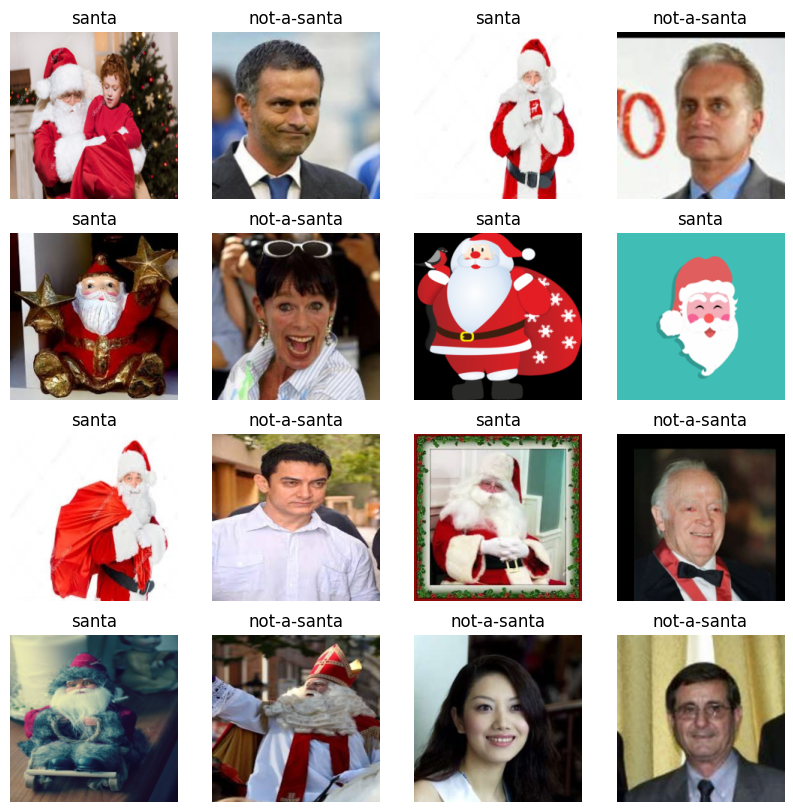

In [19]:
class_names = train_dataset.classes
images, labels = next(iter(train_loader))

rows = 4
columns = 4
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(rows, columns, i + 1)
    plt.title(class_names[labels[i].item()])
    img = images[i].cpu().numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [20]:
print(f'количество классов в train: {len(train_dataset.classes)}')
print(f'количество изображений в train: {len(train_dataset)}')

print(f'количество классов в test: {len(test_dataset.classes)}')
print(f'количество изображений в test: {len(test_dataset)}')

количество классов в train: 2
количество изображений в train: 614
количество классов в test: 2
количество изображений в test: 616


In [43]:
class SantaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, padding=1) # 16x224x224
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 16x112x112
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 112 * 112, 128)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(self.relu1(self.conv(x)))
        x = self.flatten(x)
        x = self.relu2(self.fc1(x))
        x = self.fc2(x)
        return x

In [44]:
set_random_seed(42)
model = SantaClassifier().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
accuracy = Accuracy(task="multiclass", num_classes=2)

In [21]:
def train(model, optimizer, criterion, train_loader, test_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_acc = []
        for images, labels in tqdm(train_loader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss.append(loss.item())
            train_acc.extend((torch.argmax(outputs, dim=-1) == labels).tolist())

        train_loss = np.mean(train_loss)
        train_acc = np.mean(train_acc)

        model.eval()
        test_loss = []
        test_correct = []
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss.append(loss.item())
                test_correct.extend((torch.argmax(outputs, dim=-1) == labels).tolist())

        test_loss = np.mean(test_loss)
        test_acc = np.mean(test_correct)

        print(f'Epoch {epoch+1}/{epochs}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')

In [46]:
train(model, optimizer, criterion, train_loader, test_loader, epochs=10)

100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


Epoch 1/10, train loss: 1.0349, train acc: 0.6450, test loss: 0.6691, test acc: 0.7581


100%|██████████| 20/20 [00:08<00:00,  2.34it/s]


Epoch 2/10, train loss: 0.4189, train acc: 0.8225, test loss: 0.3761, test acc: 0.8360


100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Epoch 3/10, train loss: 0.2656, train acc: 0.8925, test loss: 0.3837, test acc: 0.8149


100%|██████████| 20/20 [00:09<00:00,  2.17it/s]


Epoch 4/10, train loss: 0.2160, train acc: 0.9104, test loss: 0.3058, test acc: 0.8750


100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Epoch 5/10, train loss: 0.1550, train acc: 0.9446, test loss: 0.3803, test acc: 0.8458


100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Epoch 6/10, train loss: 0.1175, train acc: 0.9642, test loss: 0.2671, test acc: 0.8912


100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


Epoch 7/10, train loss: 0.0870, train acc: 0.9853, test loss: 0.2870, test acc: 0.8750


100%|██████████| 20/20 [00:09<00:00,  2.17it/s]


Epoch 8/10, train loss: 0.0672, train acc: 0.9853, test loss: 0.2628, test acc: 0.8864


100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


Epoch 9/10, train loss: 0.0625, train acc: 0.9886, test loss: 0.2863, test acc: 0.8945


100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Epoch 10/10, train loss: 0.0442, train acc: 0.9951, test loss: 0.2621, test acc: 0.9010


In [22]:
def visualize_results(model, dataset, mean, std, num_images=6):
    model.eval()
    fig = plt.figure(figsize=(15, 10))

    random_indices = random.sample(range(len(dataset)), num_images) # генерируем случайные индексы

    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]

        with torch.no_grad():
            output = model(image.unsqueeze(0).to(DEVICE))
            _, pred = torch.max(output, 1)

        img = image.cpu().numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax = plt.subplot(num_images // 2, 2, i + 1)
        ax.axis('off')
        ax.set_title(f'predicted: {train_dataset.classes[pred.item()]}, actual: {train_dataset.classes[label]}')
        ax.imshow(img)

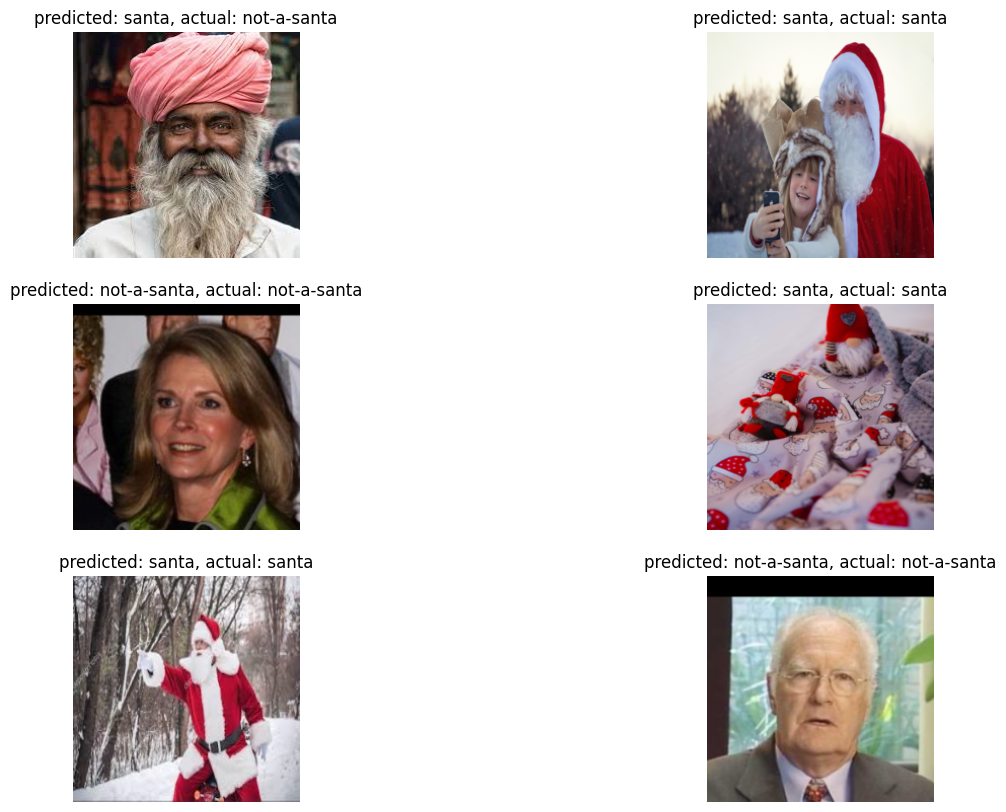

In [49]:
visualize_results(model, test_dataset, mean.numpy(), std.numpy(), num_images=6)
plt.show()

In [84]:
set_random_seed(42)

In [85]:
class SantaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # 16x224x224
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 16x112x112

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # 32x112x112
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 32x56x56

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


In [86]:
model = SantaClassifier().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9) # SGD with momentum
criterion = nn.CrossEntropyLoss()
accuracy = Accuracy(task="multiclass", num_classes=2)

In [87]:
train(model, optimizer, criterion, train_loader, test_loader, epochs=20)

100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


Epoch 1/20, train loss: 0.6076, train acc: 0.6629, test loss: 0.5526, test acc: 0.7468


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


Epoch 2/20, train loss: 0.4684, train acc: 0.7671, test loss: 0.4274, test acc: 0.8084


100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


Epoch 3/20, train loss: 0.3834, train acc: 0.8371, test loss: 0.4283, test acc: 0.8068


100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Epoch 4/20, train loss: 0.3325, train acc: 0.8453, test loss: 0.3723, test acc: 0.8279


100%|██████████| 20/20 [00:09<00:00,  2.22it/s]


Epoch 5/20, train loss: 0.3047, train acc: 0.8616, test loss: 0.3634, test acc: 0.8425


100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


Epoch 6/20, train loss: 0.2594, train acc: 0.8990, test loss: 0.3306, test acc: 0.8458


100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


Epoch 7/20, train loss: 0.2463, train acc: 0.9007, test loss: 0.3440, test acc: 0.8636


100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Epoch 8/20, train loss: 0.2238, train acc: 0.8990, test loss: 0.3346, test acc: 0.8571


100%|██████████| 20/20 [00:08<00:00,  2.22it/s]


Epoch 9/20, train loss: 0.1845, train acc: 0.9365, test loss: 0.2976, test acc: 0.8701


100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


Epoch 10/20, train loss: 0.1701, train acc: 0.9365, test loss: 0.3171, test acc: 0.8799


100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


Epoch 11/20, train loss: 0.1658, train acc: 0.9349, test loss: 0.3531, test acc: 0.8312


100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


Epoch 12/20, train loss: 0.1471, train acc: 0.9365, test loss: 0.3129, test acc: 0.8847


100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


Epoch 13/20, train loss: 0.1238, train acc: 0.9560, test loss: 0.3135, test acc: 0.8685


100%|██████████| 20/20 [00:09<00:00,  2.21it/s]


Epoch 14/20, train loss: 0.1118, train acc: 0.9691, test loss: 0.3131, test acc: 0.8604


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


Epoch 15/20, train loss: 0.1101, train acc: 0.9707, test loss: 0.3046, test acc: 0.8880


100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Epoch 16/20, train loss: 0.0924, train acc: 0.9756, test loss: 0.2772, test acc: 0.8766


100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


Epoch 17/20, train loss: 0.0861, train acc: 0.9739, test loss: 0.2912, test acc: 0.8718


100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


Epoch 18/20, train loss: 0.0735, train acc: 0.9853, test loss: 0.2748, test acc: 0.8912


100%|██████████| 20/20 [00:08<00:00,  2.37it/s]


Epoch 19/20, train loss: 0.0692, train acc: 0.9853, test loss: 0.2963, test acc: 0.8977


100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


Epoch 20/20, train loss: 0.1112, train acc: 0.9560, test loss: 0.2894, test acc: 0.8750


Пробовал разные оптимизаторы (Adam, SGD), значения learning rate и архитектуры модели, но лучший результат (acc = 0.9) пока с Adam и lr=0.0001.

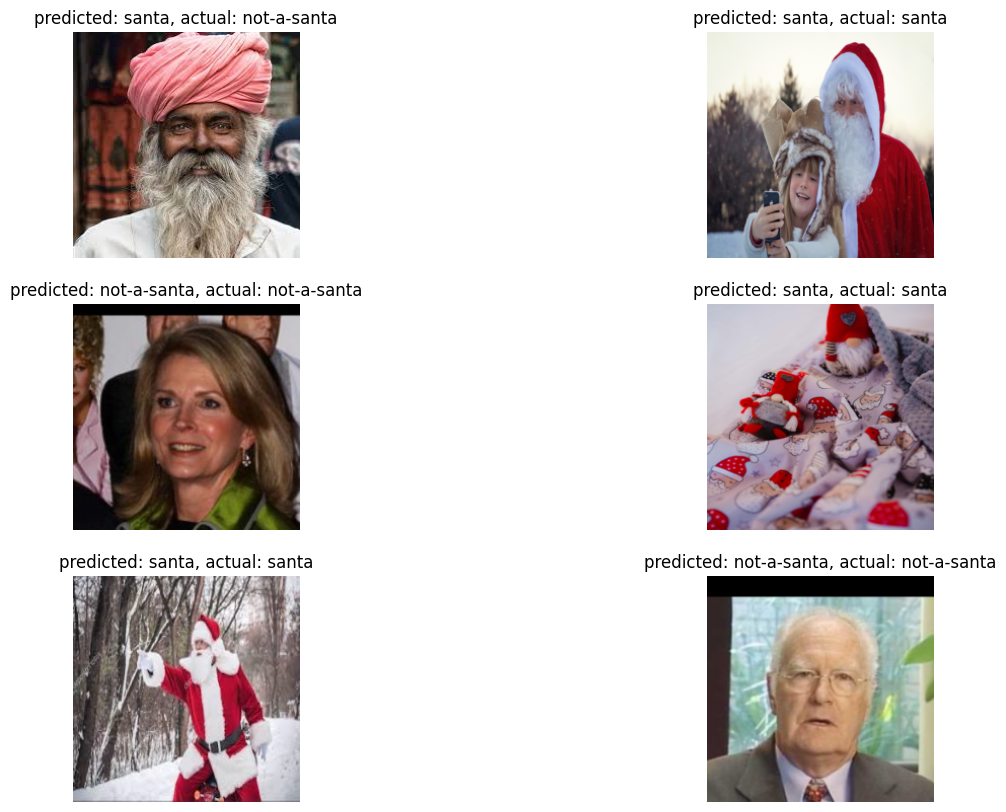

In [55]:
visualize_results(model, test_dataset, mean.numpy(), std.numpy(), num_images=6)
plt.show()

Воспользуемся предобученной моделью ResNet

In [71]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights

In [76]:
set_random_seed(42)

In [77]:
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

number_features = model.fc.in_features
model.fc = nn.Linear(number_features, 2)

model = model.to(DEVICE)

In [78]:
optimizer = optim.Adam(model.fc.parameters(), lr=0.0005) # обучаем только последний слой
criterion = nn.CrossEntropyLoss()
accuracy = Accuracy(task="multiclass", num_classes=2)

In [79]:
train(model, optimizer, criterion, train_loader, test_loader, epochs=10)

100%|██████████| 20/20 [00:07<00:00,  2.67it/s]


Epoch 1/10, train loss: 0.5599, train acc: 0.7459, test loss: 0.3951, test acc: 0.8912


100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Epoch 2/10, train loss: 0.3594, train acc: 0.8876, test loss: 0.3062, test acc: 0.8945


100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


Epoch 3/10, train loss: 0.3085, train acc: 0.9023, test loss: 0.2312, test acc: 0.9302


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch 4/10, train loss: 0.2497, train acc: 0.9267, test loss: 0.2075, test acc: 0.9464


100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


Epoch 5/10, train loss: 0.2278, train acc: 0.9397, test loss: 0.1880, test acc: 0.9481


100%|██████████| 20/20 [00:07<00:00,  2.55it/s]


Epoch 6/10, train loss: 0.1938, train acc: 0.9414, test loss: 0.1814, test acc: 0.9481


100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


Epoch 7/10, train loss: 0.1940, train acc: 0.9511, test loss: 0.1732, test acc: 0.9464


100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


Epoch 8/10, train loss: 0.1938, train acc: 0.9381, test loss: 0.1639, test acc: 0.9497


100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


Epoch 9/10, train loss: 0.1907, train acc: 0.9463, test loss: 0.1605, test acc: 0.9513


100%|██████████| 20/20 [00:07<00:00,  2.61it/s]


Epoch 10/10, train loss: 0.1673, train acc: 0.9397, test loss: 0.1551, test acc: 0.9545


точность с resnet выросла до 95.45%

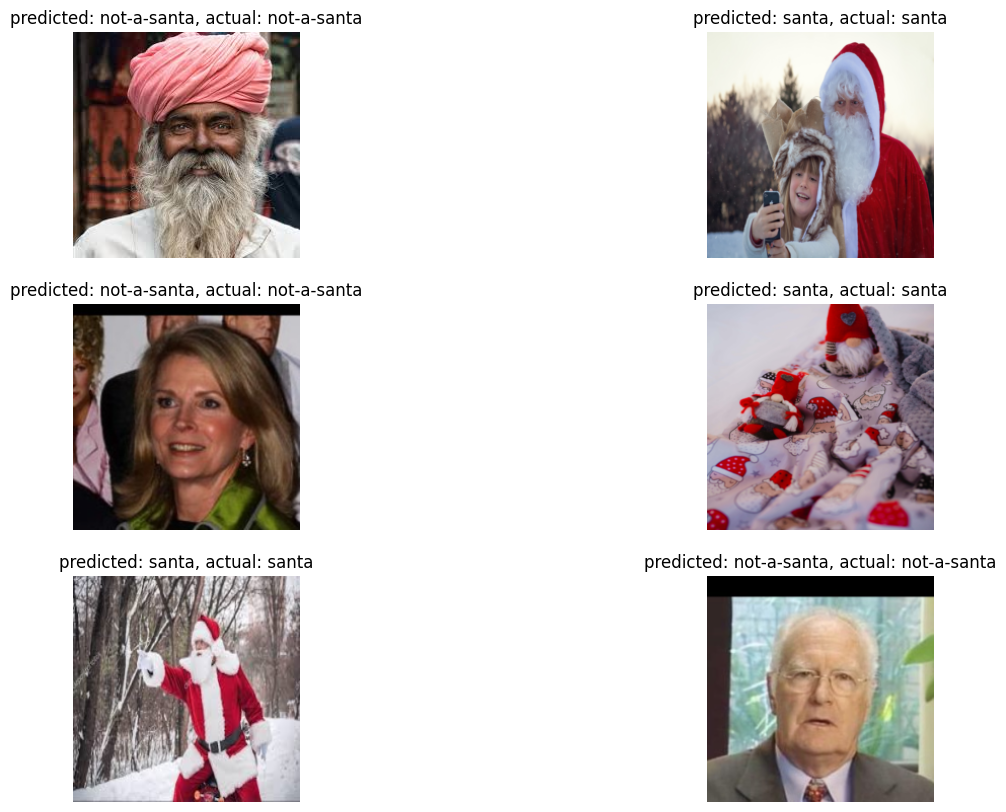

In [62]:
visualize_results(model, test_dataset, mean.numpy(), std.numpy(), num_images=6)
plt.show()

вау, даже индиец больше не распознается как санта :D

В целом, это не самый сложный датасет, поэтому даже сверточная неройнная сеть с относительно простой архитектурой показала достаточно высокую точность (\~90%). Применение же предобученной модели ResNet дало еще более высокий результат (\~95%).
